In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score)
import statsmodels.formula.api as sma
# set up path to import my python scripts
import sys
import os
src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path+"/src")
    
%load_ext autoreload
%autoreload 2
import clean_df

from matplotlib import rcParams
rcParams.update({'font.size': 16})
sns.set(font_scale = 2)
# rcParams.update({"figure.facecolor": 'gray'})
# rcParams.update({"axes.facecolor": 'gray'})
# rcParams.update({"savefig.facecolor": 'gray'})
#sns.set(rc = {'figure.figsize':(15,8)})

#import data from 2013-2014 NHANES: https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey
#description of columns: https://wwwn.cdc.gov/nchs/nhanes/2013-2014/demo_h.htm
demo_df = pd.read_csv('../data/demographic.csv')
diet_df = pd.read_csv('../data/diet.csv')
exam_df = pd.read_csv('../data/examination.csv')
labs_df = pd.read_csv('../data/labs.csv')
med_df = pd.read_csv('../data/medications.csv', encoding='latin1')
ques_df = pd.read_csv('../data/questionnaire.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 1: EDA

In [230]:
new_demo_df = demo_df[['SEQN','RIAGENDR','RIDAGEYR','RIDRETH3',
'DMQMILIZ','DMQADFC','DMDBORN4','DMDMARTL']]

In [231]:
'''
demo_df feature descriptions:
------------------------------
SEQN: Participant sequence number
RIAGENDR: Particpant gender
	1 -> Male
	2 -> Female
RIDAGEYR: Age in years
RIDRETH3: Race/Hispanic origin w/ NH Asian
	1 -> Mexican American
	2 -> Other Hispanic
	3 -> Non-Hispanic White
	4 -> Non-Hispanic Black
	6 -> Non-Hispanic Asian
	7 -> Other Race - Including Multi-Racial
DMQMILIZ: Served active duty in US Armed Forces
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMQADFC: Served in a foreign country
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMDBORN4: Country of birth
	1 -> Born in US
	2 -> Others
	77 -> Refused
	99 -> Don't Know
	. -> Missing
DMDMARTL: Marital Status
	1 -> Married
	2 -> Widowed
	3 -> Divorced
	4 -> Separated
	5 -> Never married
	6 -> Living with partner
	77 -> Refused
	99 -> Don't Know
	. -> Missing
'''

"\ndemo_df feature descriptions:\n------------------------------\nSEQN: Participant sequence number\nRIAGENDR: Particpant gender\n\t1 -> Male\n\t2 -> Female\nRIDAGEYR: Age in years\nRIDRETH3: Race/Hispanic origin w/ NH Asian\n\t1 -> Mexican American\n\t2 -> Other Hispanic\n\t3 -> Non-Hispanic White\n\t4 -> Non-Hispanic Black\n\t6 -> Non-Hispanic Asian\n\t7 -> Other Race - Including Multi-Racial\nDMQMILIZ: Served active duty in US Armed Forces\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMQADFC: Served in a foreign country\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMDBORN4: Country of birth\n\t1 -> Born in US\n\t2 -> Others\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\nDMDMARTL: Marital Status\n\t1 -> Married\n\t2 -> Widowed\n\t3 -> Divorced\n\t4 -> Separated\n\t5 -> Never married\n\t6 -> Living with partner\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\n"

In [232]:
new_df = clean_df.DemographicDF()
exam_df = clean_df.ExamDF()
new_df.left_merge(exam_df)
labs_df = clean_df.LabsDF()
new_df.left_merge(labs_df)

In [233]:
new_df.df.head()

,SEQN,RIDAGEYR,DMQMILIZ,DMDMARTL,RIAGENDR,RIDRETH3,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
0,73557,69,Yes,Separated,Male,Black,112.666667,74.000000,0.0,0.0,45.4,NaN
1,73558,54,No,Married,Male,White,157.333333,61.333333,1.0,0.0,36.7,NaN
2,73559,72,Yes,Married,Male,White,142.000000,82.000000,1.0,1.0,49.9,51.0
3,73560,9,NaN,NaN,Male,White,104.666667,36.666667,0.0,0.0,37.8,NaN
4,73561,73,No,Married,Female,White,137.333333,86.666667,1.0,1.0,43.8,75.0


In [234]:
new_df.df.describe()

,SEQN,RIDAGEYR,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
count,10175.000000,10175.000000,7531.000000,7531.000000,9813.000000,9813.000000,8544.000000,3146.000000
mean,78644.000000,31.484128,118.314566,65.442438,0.170692,0.098033,40.441959,112.306739
std,2937.413829,24.421651,18.061353,14.839116,0.376259,0.297375,4.106112,115.607060
min,73557.000000,0.000000,64.666667,0.000000,0.000000,0.000000,17.900000,13.000000
25%,76100.500000,10.000000,106.000000,58.000000,0.000000,0.000000,37.700000,60.000000
50%,78644.000000,26.000000,115.333333,66.666667,0.000000,0.000000,40.200000,88.000000
75%,81187.500000,52.000000,128.000000,74.666667,0.000000,0.000000,43.200000,133.000000
max,83731.000000,80.000000,228.666667,128.000000,1.000000,1.000000,56.500000,4233.000000


In [235]:
test_df = new_df.df.copy()
test_df = test_df[test_df['LBXTR']< 4000]
nicotine = test_df['LBXHCT']
avg_sys_bp = test_df['AVG_SYS_BP']
#test_df = test_df.dropna()

In [236]:
#reg_df.head()
mil_dummy = demo_df['DMQMILIZ']
mar_dummy = demo_df['DMDMARTL']
gen_dummy = demo_df['RIAGENDR']
eth_dummy = demo_df['RIDRETH3']

mil_dummy = mil_dummy.apply(lambda x: np.nan if x == 7.0 else x)
mar_dummy = mar_dummy.apply(lambda x: np.nan if x == 77.0 or x == 99.0 else x)

In [237]:
reg_df = test_df.copy()
reg_df['DMQMILIZ'] = mil_dummy
reg_df['DMDMARTL'] = mar_dummy
reg_df['RIAGENDR'] = gen_dummy
reg_df['RIDRETH3'] = eth_dummy

reg_df.head()

,SEQN,RIDAGEYR,DMQMILIZ,DMDMARTL,RIAGENDR,RIDRETH3,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
2,73559,72,1.0,1.0,1,3,142.000000,82.000000,1.0,1.0,49.9,51.0
4,73561,73,2.0,1.0,2,3,137.333333,86.666667,1.0,1.0,43.8,75.0
7,73564,61,2.0,2.0,2,3,122.666667,80.666667,0.0,1.0,39.8,64.0
11,73568,26,2.0,5.0,2,3,104.666667,62.666667,0.0,0.0,44.2,24.0
17,73574,33,2.0,1.0,2,6,121.333333,62.000000,0.0,0.0,35.6,14.0


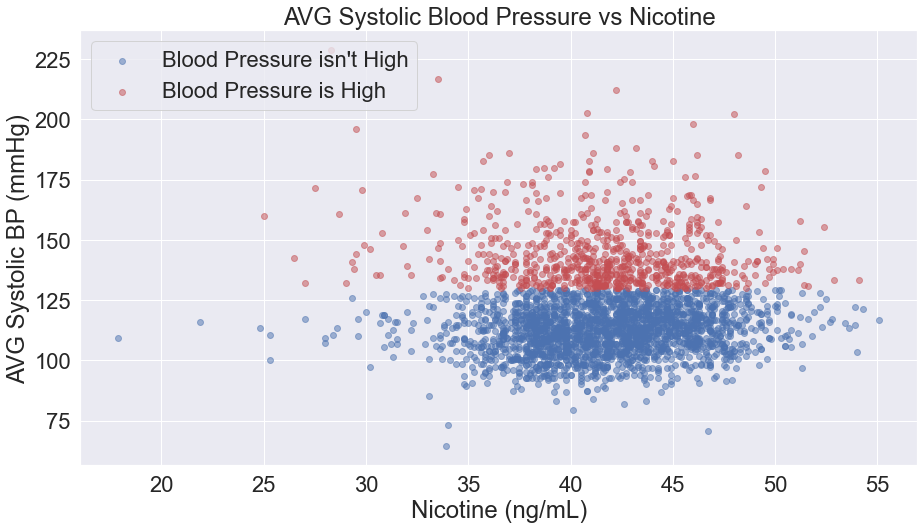

In [238]:
#AVG Systolic BP vs Nicotine (Hydroxycotinine, Serum (ng/mL))
fig, ax = plt.subplots()

xy_0 = test_df[test_df['High_SYS_BP']==False]
xy_1 = test_df[test_df['High_SYS_BP']==True]

x_0 = xy_0['LBXHCT']
y_0 = xy_0['AVG_SYS_BP']

x_1 = xy_1['LBXHCT']
y_1 = xy_1['AVG_SYS_BP']

# x = test_df['LBXHCT']
# y = test_df['AVG SYS BP']

ax.scatter(x=x_0,y=y_0,color='b',label="Blood Pressure isn't High", alpha=0.5)
ax.scatter(x=x_1,y=y_1,color='r',label='Blood Pressure is High', alpha=0.5)
plt.title("AVG Systolic Blood Pressure vs Nicotine")
plt.xlabel("Nicotine (ng/mL)")
plt.ylabel("AVG Systolic BP (mmHg)")
ax.legend(loc='upper left')

plt.show()

<AxesSubplot:xlabel='LBXTR', ylabel='High_SYS_BP'>

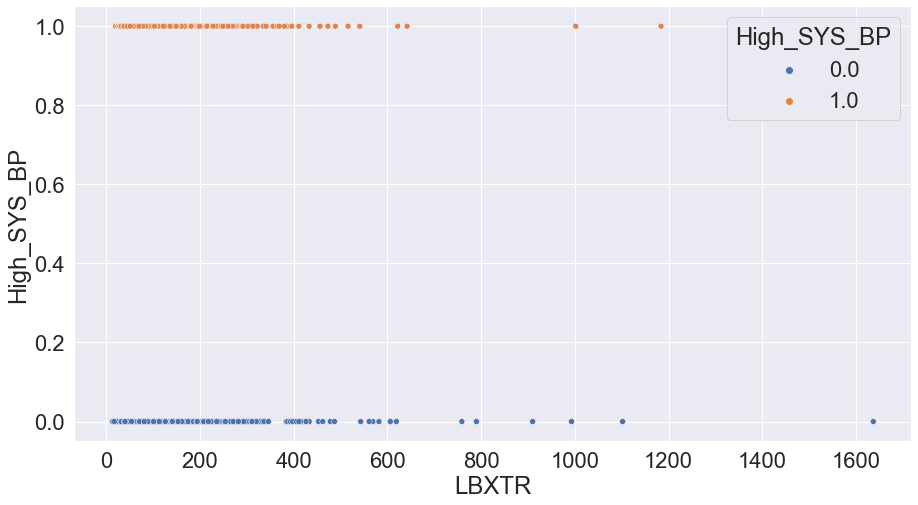

In [239]:
sns.scatterplot(x='LBXTR', y='High_SYS_BP',hue='High_SYS_BP',data=test_df)

Text(0.5, 1.0, 'Distribution of Nicotine Levels')

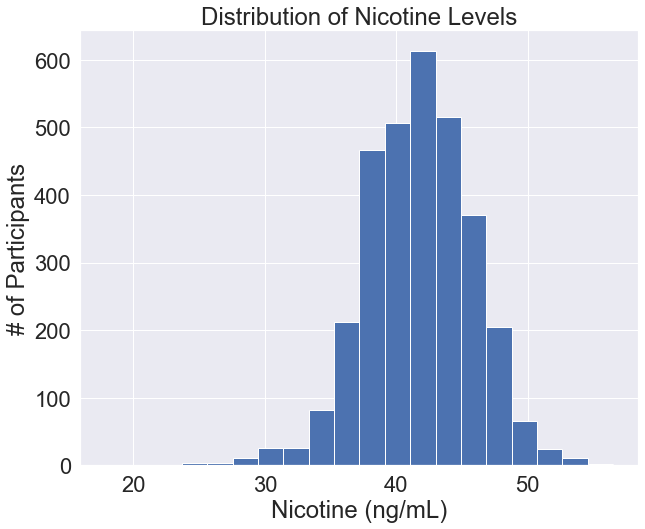

In [240]:
fig, ax = plt.subplots(figsize=(10,8))

ax = plt.hist(x=nicotine,bins=20)
plt.xlabel("Nicotine (ng/mL)")
plt.ylabel("# of Participants")
plt.title("Distribution of Nicotine Levels")

Text(0.5, 1.0, 'Distribution of Blood Pressures')

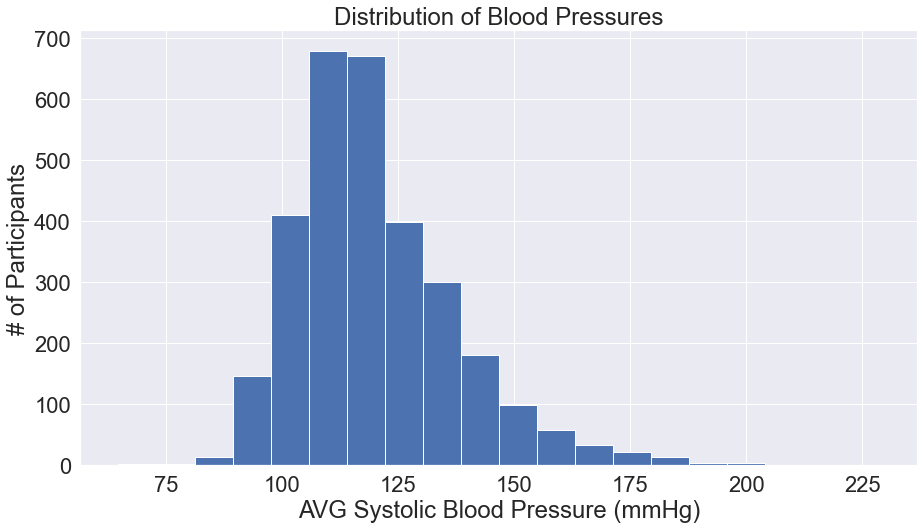

In [241]:
fig, ax = plt.subplots()

ax = plt.hist(x=avg_sys_bp,bins=20)
plt.xlabel("AVG Systolic Blood Pressure (mmHg)")
plt.ylabel("# of Participants")
plt.title("Distribution of Blood Pressures")

In [242]:
test_df.head()

,SEQN,RIDAGEYR,DMQMILIZ,DMDMARTL,RIAGENDR,RIDRETH3,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
2,73559,72,Yes,Married,Male,White,142.000000,82.000000,1.0,1.0,49.9,51.0
4,73561,73,No,Married,Female,White,137.333333,86.666667,1.0,1.0,43.8,75.0
7,73564,61,No,Widowed,Female,White,122.666667,80.666667,0.0,1.0,39.8,64.0
11,73568,26,No,Never married,Female,White,104.666667,62.666667,0.0,0.0,44.2,24.0
17,73574,33,No,Married,Female,Asian,121.333333,62.000000,0.0,0.0,35.6,14.0


Text(84.75, 0.5, 'Average Systolic BP')

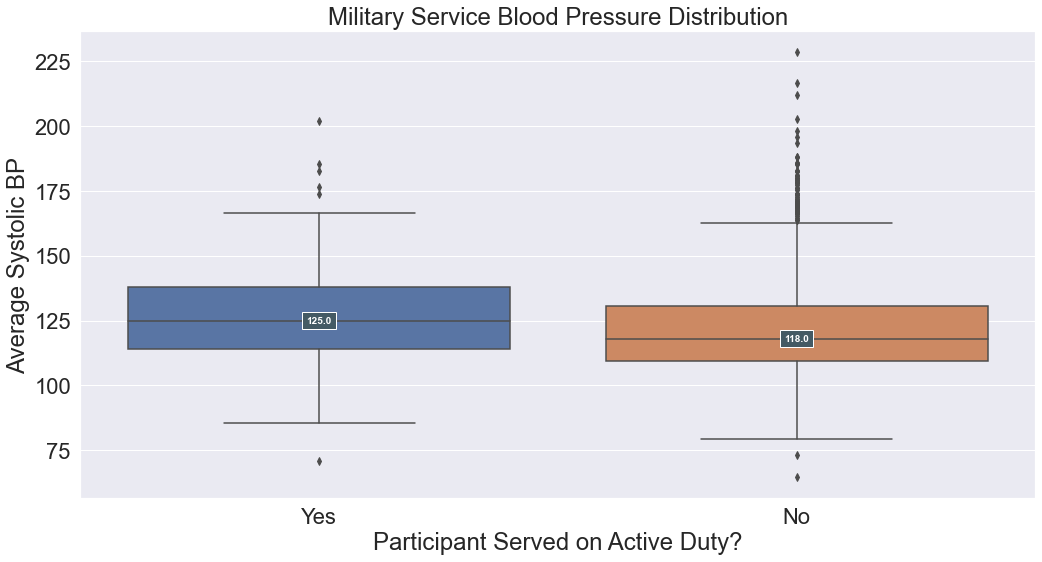

In [243]:
mil_box_plot = sns.boxplot(x='DMQMILIZ', y='AVG_SYS_BP',data=test_df)

ax = mil_box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

mil_box_plot.figure.tight_layout()
plt.title("Military Service Blood Pressure Distribution")
plt.xlabel("Participant Served on Active Duty?")
plt.ylabel("Average Systolic BP")

Text(97.0, 0.5, 'Nicotine Levels (ng/mL)')

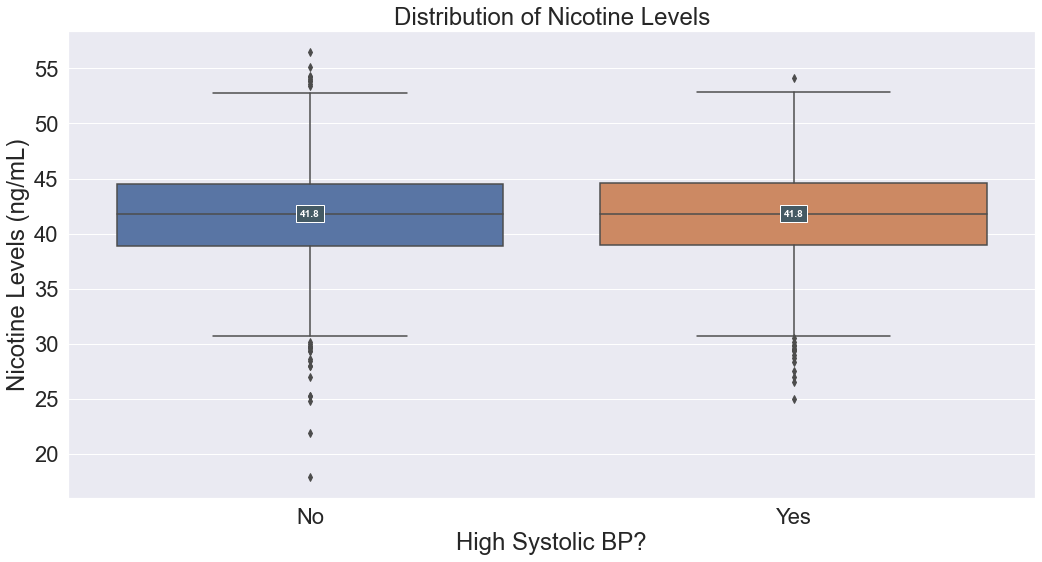

In [253]:
nicotine_plot = sns.boxplot(x='High_SYS_BP', y='LBXHCT',data=test_df)

ax = nicotine_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'No'
labels[1] = 'Yes'

ax.set_xticklabels(labels)

nicotine_plot.figure.tight_layout()
plt.title("Distribution of Nicotine Levels")
plt.xlabel("High Systolic BP?")
plt.ylabel("Nicotine Levels (ng/mL)")

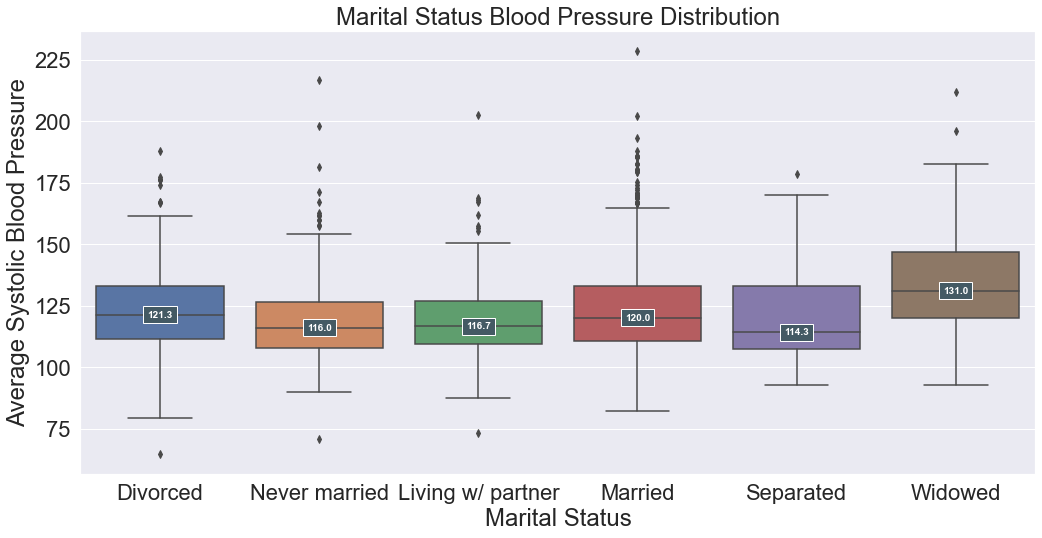

In [256]:
marital_plot_df = test_df[['AVG_SYS_BP','DMDMARTL']].sort_values(['AVG_SYS_BP'])

marital_plot = sns.boxplot(y='AVG_SYS_BP', x='DMDMARTL',data=marital_plot_df)

ax = marital_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

plt.title("Marital Status Blood Pressure Distribution")
plt.ylabel("Average Systolic Blood Pressure")
plt.xlabel("Marital Status")
plt.tight_layout()

Text(0.5, 38.5, 'Gender')

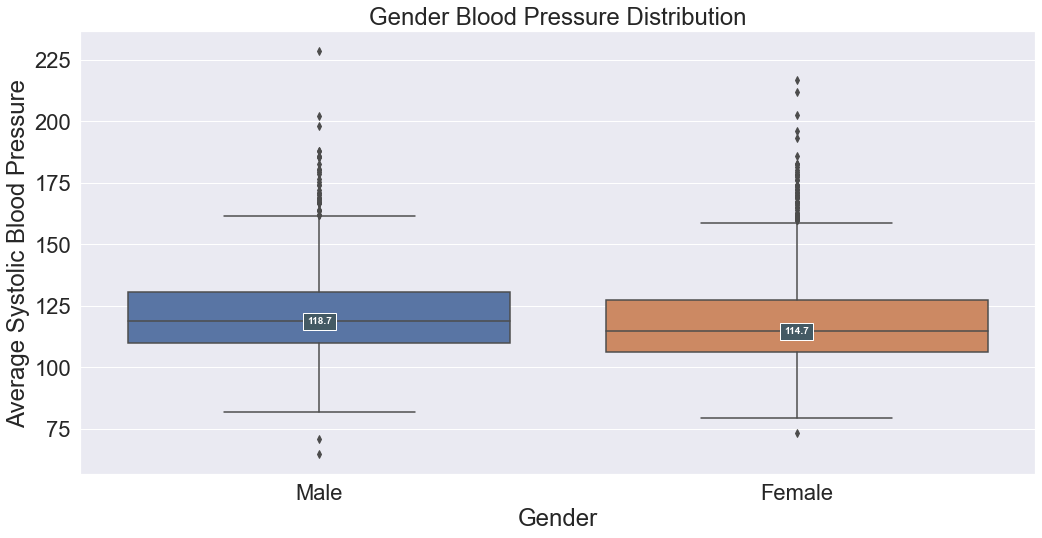

In [246]:
gender_plot = sns.boxplot(x='RIAGENDR', y='AVG_SYS_BP',data=test_df)
plt.title("Gender Blood Pressure Distribution")

ax = gender_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

gender_plot.figure.tight_layout()

plt.title("Gender Blood Pressure Distribution")
plt.ylabel("Average Systolic Blood Pressure")
plt.xlabel("Gender")

#plt.xlabel("Average Systolic Blood Pressure")
#plt.ylabel("Marital Status")

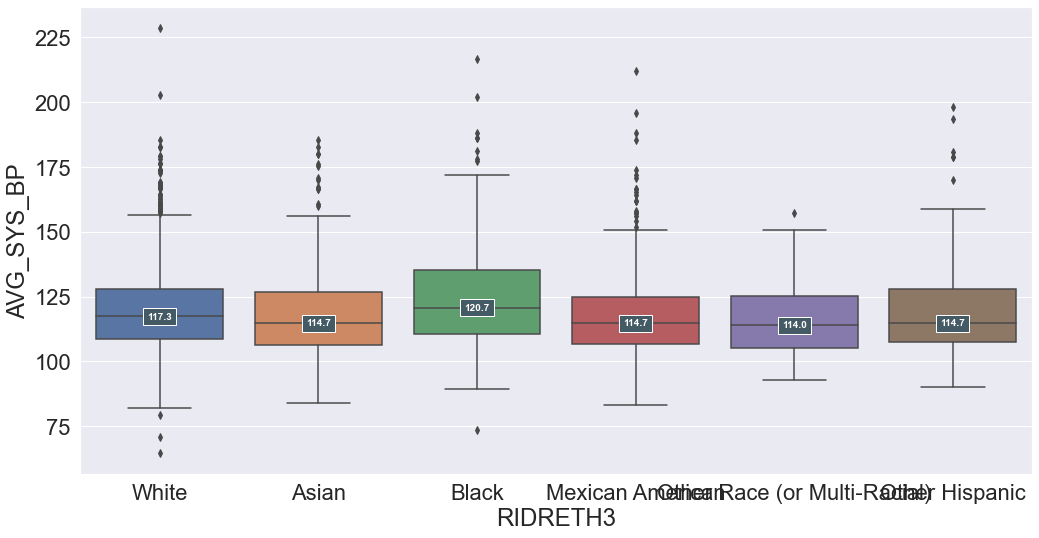

In [247]:
eth_plot = sns.boxplot(y='AVG_SYS_BP', x='RIDRETH3',data=test_df)

ax = eth_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

eth_plot.figure.tight_layout()

<AxesSubplot:xlabel='RIDAGEYR', ylabel='AVG_SYS_BP'>

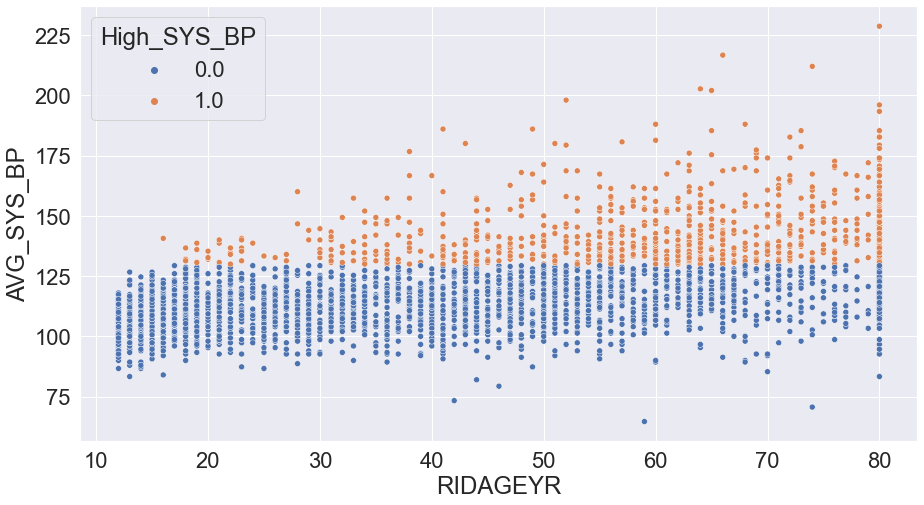

In [248]:
#avg_age_df = reg_df.groupby(['RIDAGEYR'])['High_SYS_BP'].mode()
sns.scatterplot(x='RIDAGEYR', y='AVG_SYS_BP',hue='High_SYS_BP',data=reg_df)

In [249]:
test_df.head()

,SEQN,RIDAGEYR,DMQMILIZ,DMDMARTL,RIAGENDR,RIDRETH3,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
2,73559,72,Yes,Married,Male,White,142.000000,82.000000,1.0,1.0,49.9,51.0
4,73561,73,No,Married,Female,White,137.333333,86.666667,1.0,1.0,43.8,75.0
7,73564,61,No,Widowed,Female,White,122.666667,80.666667,0.0,1.0,39.8,64.0
11,73568,26,No,Never married,Female,White,104.666667,62.666667,0.0,0.0,44.2,24.0
17,73574,33,No,Married,Female,Asian,121.333333,62.000000,0.0,0.0,35.6,14.0


In [250]:
xy_values = test_df[['LBXHCT','High_SYS_BP']]
xy_values = xy_values.dropna()
x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
y_values = xy_values['High_SYS_BP'].to_numpy().astype('int')

xy_0 = xy_values[xy_values['High_SYS_BP']==False]
xy_1 = xy_values[xy_values['High_SYS_BP']==True]

x_0 = xy_0['LBXHCT']
y_0 = xy_0['High_SYS_BP']

x_1 = xy_1['LBXHCT']
y_1 = xy_1['High_SYS_BP']

model = lm.LogisticRegression()
results = model.fit(X=x_values,y=y_values)





plt.title("Marital Status Blood Pressure Distribution")
plt.ylabel("Average Systolic Blood Pressure")
plt.xlabel("Marital Status")kk
x = np.linspace(0,500,500).reshape(-1,1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(x_0, y_0, color='b',label='Not High Blood Pressure')
ax.scatter(x_1, y_1, color='r',label='High Blood Pressure')
ax.plot(x, model.predict_proba(x)[:,1], 'k--', label='Prob of High BP')
ax.set_xlim([10,200])
ax.set_ylabel('Has High Systolic Blood Pressure?')
ax.set_xlabel('Nicotine (Hydroxycotinine, Serum (ng/mL))')
plt.title("High Blood Pressure Logit")
plt.legend()
plt.show()

SyntaxError: invalid syntax (686012307.py, line 24)

In [ ]:
formula = 'High_SYS_BP ~ LBXHCT'
model_1 = sma.logit(formula=formula, data=test_df).fit()
model_1.summary()

Optimization terminated successfully.
         Current function value: 0.545670
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_SYS_BP   No. Observations:                 3143
Model:                          Logit   Df Residuals:                     3141
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Jan 2022   Pseudo R-squ.:               0.0001857
Time:                        12:25:34   Log-Likelihood:                -1715.0
converged:                       True   LL-Null:                       -1715.4
Covariance Type:            nonrobust   LLR p-value:                    0.4248
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8382      0.427     -1.963      0.050      -1.675      -0.002
LBXHCT        -0.0082      0.010     -0.799      0.424      -0.028       0.012
==============================================================================
"""

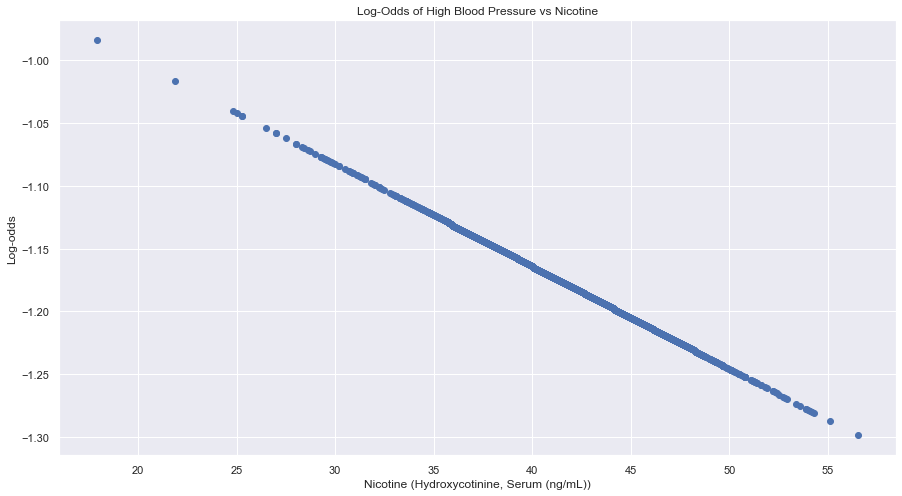

In [ ]:
x_values = xy_values['LBXHCT']
predicted = model_1.predict(x_values)

log_odds = np.log(predicted / (1-predicted))

plt.scatter(x = x_values, y = log_odds)
plt.title("Log-Odds of High Blood Pressure vs Nicotine")
plt.xlabel("Nicotine (Hydroxycotinine, Serum (ng/mL))")
plt.ylabel("Log-odds")
plt.show()

In [ ]:
xy_values = test_df[['LBXHCT','High_SYS_BP']]
xy_values = xy_values.dropna()
xy_values['High_SYS_BP'].value_counts()
print(1578+3632)

5210


In [ ]:
reg_df.head()

,SEQN,RIDAGEYR,DMQMILIZ,DMDMARTL,RIAGENDR,RIDRETH3,AVG_SYS_BP,AVG_DIAS_BP,High_SYS_BP,High_DIAS_BP,LBXHCT,LBXTR
2,73559,72,1.0,1.0,1,3,142.000000,82.000000,1.0,1.0,49.9,51.0
4,73561,73,2.0,1.0,2,3,137.333333,86.666667,1.0,1.0,43.8,75.0
7,73564,61,2.0,2.0,2,3,122.666667,80.666667,0.0,1.0,39.8,64.0
11,73568,26,2.0,5.0,2,3,104.666667,62.666667,0.0,0.0,44.2,24.0
17,73574,33,2.0,1.0,2,6,121.333333,62.000000,0.0,0.0,35.6,14.0


In [ ]:
formula2 = 'High_SYS_BP ~ RIDAGEYR + DMQMILIZ + DMDMARTL + RIAGENDR + RIDRETH3 + LBXHCT + LBXTR'
model_2 = sma.logit(formula=formula2, data=reg_df).fit()
model_2.summary()

Optimization terminated successfully.
         Current function value: 0.525869
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_SYS_BP   No. Observations:                 2549
Model:                          Logit   Df Residuals:                     2541
Method:                           MLE   Df Model:                            7
Date:                Wed, 05 Jan 2022   Pseudo R-squ.:                  0.1230
Time:                        12:25:35   Log-Likelihood:                -1340.4
converged:                       True   LL-Null:                       -1528.4
Covariance Type:            nonrobust   LLR p-value:                 3.531e-77
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.9506      0.753     -5.247      0.000      -5.426      -2.475
RIDAGEYR       0.0547      0.003     16.537      0.000       0.048       0.061
DMQMILIZ       0.3396      0.163      2.082      0.037       0.020       0.659
DMDMARTL       0.0722      0.029      2.466      0.014       0.015       0.130
RIAGENDR      -0.3807      0.115     -3.308      0.001      -0.606      -0.155
RIDRETH3       0.1084      0.033      3.311      0.001       0.044       0.173
LBXHCT        -0.0153      0.013     -1.178      0.239      -0.041       0.010
LBXTR          0.0016      0.000      3.295      0.001       0.001       0.003
==============================================================================
"""

In [ ]:
formula2 = 'High_SYS_BP ~ RIDAGEYR + DMQMILIZ + DMDMARTL + RIAGENDR + RIDRETH3 + LBXTR'
model_2 = sma.logit(formula=formula2, data=reg_df).fit()
model_2.summary()

Optimization terminated successfully.
         Current function value: 0.526153
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_SYS_BP   No. Observations:                 2551
Model:                          Logit   Df Residuals:                     2544
Method:                           MLE   Df Model:                            6
Date:                Wed, 05 Jan 2022   Pseudo R-squ.:                  0.1227
Time:                        12:25:35   Log-Likelihood:                -1342.2
converged:                       True   LL-Null:                       -1530.0
Covariance Type:            nonrobust   LLR p-value:                 5.162e-78
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.6955      0.425    -11.051      0.000      -5.528      -3.863
RIDAGEYR       0.0552      0.003     16.771      0.000       0.049       0.062
DMQMILIZ       0.3267      0.163      2.010      0.044       0.008       0.645
DMDMARTL       0.0728      0.029      2.489      0.013       0.015       0.130
RIAGENDR      -0.3139      0.102     -3.080      0.002      -0.514      -0.114
RIDRETH3       0.1118      0.033      3.423      0.001       0.048       0.176
LBXTR          0.0015      0.000      3.188      0.001       0.001       0.002
==============================================================================
"""